Modelagem  e Avaliação<br> 
Neste tópico, iremos preparar nossos dados para modelagem, criando pipeline para garatir o correto pré-processamento dos nossos dados.Utilizaremos o modelo RandomForestClassifier, um modelo que me sinto bastante confortável por conhecer seu funcionamento e nuances. É um modelo não-linear, robusto a outliers e que não possui qualquer suposição sobre as distribuições, o que é algo bastante relevante, dado que a maioria dos dados na vida real apresentam não normalidade. Evitar a normalização é uma etapa a menos se você utiliza modelos baseados em árvore. Em suma, o RandomForest cria várias árvores de decisões, as quais são construídas com diferentes dados de um mesmo dataset (Bootstrap). Dessa maneira, o resultado final é obtido por votação majoritária. Vale ressaltar também que estamos lidando com um problema de classificação múltipla. O RandomForestClassifier é por natureza um modelo que lida com esse tipo de problema, sem precisar aplicar técnicas como One vs One ou One vs Rest.

# Dependências

In [1]:
#Importanto bibliotecas.
#import sys
#!{sys.executable} -m pip install yellowbrick
import warnings 
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cloudpickle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, recall_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from src.modelagem_metricas import naive_classifiers
from sklearn import set_config
import optuna
from optuna.samplers import TPESampler
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

In [2]:
#Constantes
DATA_RAW_PATH = os.path.join('..','data','raw')
DATA_RAW_NAME = 'Safra_2018-2019.csv'
DATA_INTER_PATH = os.path.join('..','data','inter')
DATA_INTER_TEST_NAME = 'test_inter.csv'
DATA_INTER_TRAIN_FT_SELECTION = 'train_inter_ft_selection.csv'
DATA_SAFRA_2020_PATH = os.path.join('..','data', 'raw')
DATA_SAFRA_2020_NAME = 'Safra_2020.csv'
IMG_PATH = os.path.abspath(os.path.join('..','img'))
META_DATA_PATH = os.path.join(DATA_RAW_PATH,'dicionario_tipos.pkl')
MODEL_PATH = os.path.join('..','models')
MODEL_NAME = 'clf_safra.pkl'
PREDICT_2020_PATH = os.path.join('..','data','results')
PREDICT_2020_NAME = 'previsao_safra_2020.csv'
DATA_PROCESSED_PATH = os.path.join('..','data','processed')
DATA_TRAIN_PROCESSED_NAME = 'train_processed.csv'
DATA_TEST_PROCESSED_NAME = 'test_processed.csv'
#TARGET = 'dano_na_plantacao'

In [3]:
with open(META_DATA_PATH,'rb') as f:
    dicionario_tipo = cloudpickle.load(f)

In [4]:
# DataSet que será utilizado para modelagem, depois da seleção de features.
df_train = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TRAIN_FT_SELECTION), dtype=dicionario_tipo)
#Lendo dados de teste.
df_test = pd.read_csv(os.path.join(DATA_INTER_PATH, DATA_INTER_TEST_NAME), dtype=dicionario_tipo, index_col=0)

In [5]:
df_train.head()

,Semanas_Utilizando,Semanas_Sem_Uso,Estimativa_de_Insetos,Doses_Semana,Tipo_de_Cultivo,Categoria_Pesticida,dano_na_plantacao
0,12.0,19,984,25,0,2,0
1,27.0,7,851,20,0,2,0
2,27.0,0,283,35,0,3,0
3,50.0,0,2542,15,0,3,2
4,14.0,24,850,30,0,2,0


# Criando Pipeline

Aqui iremos criar um pipeline para tratar dados categóricos e outro para tratar nossos dados numéricos. Dessa maneira cada coluna é tratada da forma mais adequada. O resultado é combinado no final e passado para o classificador, último componente do pipeline.

In [6]:
#Separando as variáveis categóricas e numéricas
variaveis_categoricas = df_train.select_dtypes(include=['object']).columns.tolist()
variaveis_numericas = df_train.select_dtypes(include=['int','float']).columns.tolist()

In [7]:
#Removendo target das variáveis categóricas. 
target = 'dano_na_plantacao'
variaveis_categoricas.remove(target)

Para tratamento dos dados categóricos foi utilizado o OrdinalEncoder. Porém, outras formas poderiam ter sido abordadas, tais como, OneHotEncoder, TargetEncoder, FrequencyEncoder, BinaryEncoder. 
Nesse caso, por estarmos utilizando um modelo baseado em árvores de decisão, a utilização de OneHotEncoder prejudica, quase sempre, a performance [Clique Aqui Para Saber Mais](https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769), além de criar complexidade adicionando mais colunas. Além disso, o modelo perde em interpretabilidade, uma vez que a varíavel é divida em mais de uma coluna, e tende a ser menos importante nos splits das árvores. Estratégias como TargetEncoder e FrequencyEncoder criam correlação com o target e isso é até bom quando o target é ordinal, o que não é nosso caso, e tendem ao overfitting com mais facilidade, pois se baseiam na distribuição dos dados de treino. Ou seja, basta termos um shift populacional, para esses encoders "quebrarem" levando a uma má performance em produção. Só devemos utilizá-los quando temos baixas chances de shift populacional. Como estamos lidando com dados temporais (2018, 2019 e 2020), talvez não seja a melhor ideia. Por fim, O BinaryEncoder, apesar de produzir menos colunas em relação ao OneHotEncoder, mesmo assim adiciona complexidade. Dessa forma, apesar de ter a chance de criarmos um pouco de correlação com o target, decidimos utilizar o OrdinalEncoder, dados os motivos acima.


Em relação ao tratamento de missing values, decidi utilizar a mediana para valores númericos e a moda para dados categóricos. Na exploração dos dados, vimos que menos de 10% dos dados estavam faltando, o que favorece o preenchimento por meio dessas estratégias. Isso, pois com uma maior volumetria de dados faltosos, poderíamos estar enviesando nosso modelo. 
Vale salientar que outras estratégias podem ser tentadadas, tais como, InterativeImputer, MICE ou até mesmo métodos baseados em árvores de decisão e KNN. Dado que isso acrescenta complexidade ao pipeline, decidimos prosseguir de uma maneira mais simples, dado que o foco não é tanto a performance.

In [8]:
# pipe numérico será tratado imputando a mediana
pipeline_numerico = Pipeline(steps=[('impute', SimpleImputer(strategy='median'))])
# pipe categórico será tratado com imputação através da moda e ordinal encoder
pipeline_categorico = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                         ('ordinal_encoder', OrdinalEncoder())])

In [9]:
# Column Transformer para unir os dois pipelines
preprocess_pipeline = ColumnTransformer([('pipe_categorico', pipeline_categorico, variaveis_categoricas),
                                ('pipe_numerico', pipeline_numerico, variaveis_numericas)])

In [10]:
# Definindo folds para a validação cruzada estratificada (dados desbalanceados).
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=123)

In [11]:
# Definindo modelo com random_seed e class_weight='balanced' para dar peso às classes mais raras
rf = RandomForestClassifier(random_state=0, class_weight='balanced')
# defninindo pipeline final, onde o último componente é o classificador
modelo_pipe =  Pipeline(steps =[('preprocessor',preprocess_pipeline),
                                  ('model_rf',rf)])

# Modelagem e Avaliação

A escolha da métrica de avaliação do modelo é uma das etapas mais importantes. Isso, pois a escolha errada pode levar a uma interpretação errônea do resultado, o que resulta em uma superestimação da performance. No nosso caso, a utilização da Acurácia seria um ERRO, pois as classes são desbalanceadas. Nesse sentido, a utilização do recall é mais assertiva, destancando o uso do recall médio ponderado pelo número de instâncias respectivas às classes. Nada impede, porém, de formularmos uma métrica específica de negócio que atenderá de maneira mais personalizada o problema que estamos tentando solucionar.

In [12]:
# Obtendo X e Y 
X = df_train.drop(target,axis=1)
y = df_train[target]

Aqui utilizaremos otimização bayesiana para busca dos melhores hiperparâmetros para o classificador. Poderíamos ter utilizado o GridSearchCV ou o RandomizedSearchCV, porém esses seriam mais lentos. Vale salientar que a otimização está sendo feita em cima da média de validação cruzada do recall.

## Otimização de Hiperparâmetros

In [13]:
def fitRF(trial):
    "Train RandomForest Model"
# Grid de parametros otimizados
    params ={'model_rf__max_depth': trial.suggest_int('model_rf__max_depth',2,13),
          'model_rf__min_samples_leaf': trial.suggest_int('model_rf__min_samples_leaf',2,33),
          'model_rf__min_samples_split':trial.suggest_int('model_rf__min_samples_split',2,33),
          'model_rf__n_estimators': trial.suggest_int('model_rf__n_estimators',50,300),
          'model_rf__criterion':trial.suggest_categorical('model_rf__criterion',['gini','entropy'])
      }
    earlyStop=20
    modelo_pipe.set_params(**params)


    results = np.mean(cross_val_score(modelo_pipe,X,y, cv=cv, scoring = 'recall_weighted'))

    #score = results.mean()  
    #intervalo(results)
    print(f'SCORE DE RECALL:{results}')
    return results
          

In [14]:
sampler = TPESampler(seed=123)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(sampler=sampler,direction='maximize')
study.optimize(fitRF, n_trials=25)
print(study.best_trial)

SCORE DE RECALL:0.6811562500000001


[I 2020-08-08 11:30:15,954] Trial 0 finished with value: 0.6811562500000001 and parameters: {'model_rf__max_depth': 4, 'model_rf__min_samples_leaf': 30, 'model_rf__min_samples_split': 4, 'model_rf__n_estimators': 280, 'model_rf__criterion': 'entropy'}. Best is trial 0 with value: 0.6811562500000001.


SCORE DE RECALL:0.665125


[I 2020-08-08 11:30:24,814] Trial 1 finished with value: 0.665125 and parameters: {'model_rf__max_depth': 5, 'model_rf__min_samples_leaf': 12, 'model_rf__min_samples_split': 29, 'model_rf__n_estimators': 107, 'model_rf__criterion': 'gini'}. Best is trial 0 with value: 0.6811562500000001.


SCORE DE RECALL:0.6795


[I 2020-08-08 11:30:35,605] Trial 2 finished with value: 0.6795 and parameters: {'model_rf__max_depth': 3, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 19, 'model_rf__n_estimators': 176, 'model_rf__criterion': 'entropy'}. Best is trial 0 with value: 0.6811562500000001.


SCORE DE RECALL:0.6815312499999999


[I 2020-08-08 11:31:09,887] Trial 3 finished with value: 0.6815312499999999 and parameters: {'model_rf__max_depth': 11, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 16, 'model_rf__n_estimators': 274, 'model_rf__criterion': 'entropy'}. Best is trial 3 with value: 0.6815312499999999.


SCORE DE RECALL:0.6693281249999999


[I 2020-08-08 11:31:34,498] Trial 4 finished with value: 0.6693281249999999 and parameters: {'model_rf__max_depth': 11, 'model_rf__min_samples_leaf': 21, 'model_rf__min_samples_split': 16, 'model_rf__n_estimators': 214, 'model_rf__criterion': 'gini'}. Best is trial 3 with value: 0.6815312499999999.


SCORE DE RECALL:0.683828125


[I 2020-08-08 11:31:40,698] Trial 5 finished with value: 0.683828125 and parameters: {'model_rf__max_depth': 2, 'model_rf__min_samples_leaf': 6, 'model_rf__min_samples_split': 19, 'model_rf__n_estimators': 105, 'model_rf__criterion': 'entropy'}. Best is trial 5 with value: 0.683828125.


SCORE DE RECALL:0.677234375


[I 2020-08-08 11:31:49,397] Trial 6 finished with value: 0.677234375 and parameters: {'model_rf__max_depth': 4, 'model_rf__min_samples_leaf': 22, 'model_rf__min_samples_split': 9, 'model_rf__n_estimators': 116, 'model_rf__criterion': 'gini'}. Best is trial 5 with value: 0.683828125.


SCORE DE RECALL:0.664546875


[I 2020-08-08 11:32:10,486] Trial 7 finished with value: 0.664546875 and parameters: {'model_rf__max_depth': 10, 'model_rf__min_samples_leaf': 31, 'model_rf__min_samples_split': 18, 'model_rf__n_estimators': 185, 'model_rf__criterion': 'entropy'}. Best is trial 5 with value: 0.683828125.


SCORE DE RECALL:0.664390625


[I 2020-08-08 11:32:27,817] Trial 8 finished with value: 0.664390625 and parameters: {'model_rf__max_depth': 5, 'model_rf__min_samples_leaf': 30, 'model_rf__min_samples_split': 30, 'model_rf__n_estimators': 230, 'model_rf__criterion': 'gini'}. Best is trial 5 with value: 0.683828125.


SCORE DE RECALL:0.680859375


[I 2020-08-08 11:32:36,984] Trial 9 finished with value: 0.680859375 and parameters: {'model_rf__max_depth': 3, 'model_rf__min_samples_leaf': 23, 'model_rf__min_samples_split': 24, 'model_rf__n_estimators': 144, 'model_rf__criterion': 'entropy'}. Best is trial 5 with value: 0.683828125.


SCORE DE RECALL:0.658578125


[I 2020-08-08 11:32:42,958] Trial 10 finished with value: 0.658578125 and parameters: {'model_rf__max_depth': 7, 'model_rf__min_samples_leaf': 9, 'model_rf__min_samples_split': 8, 'model_rf__n_estimators': 51, 'model_rf__criterion': 'entropy'}. Best is trial 5 with value: 0.683828125.


SCORE DE RECALL:0.701734375


[I 2020-08-08 11:32:51,661] Trial 11 finished with value: 0.701734375 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 13, 'model_rf__n_estimators': 52, 'model_rf__criterion': 'entropy'}. Best is trial 11 with value: 0.701734375.


SCORE DE RECALL:0.695140625


[I 2020-08-08 11:33:00,536] Trial 12 finished with value: 0.695140625 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 7, 'model_rf__min_samples_split': 12, 'model_rf__n_estimators': 55, 'model_rf__criterion': 'entropy'}. Best is trial 11 with value: 0.701734375.


SCORE DE RECALL:0.6829531249999999


[I 2020-08-08 11:33:09,182] Trial 13 finished with value: 0.6829531249999999 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 13, 'model_rf__min_samples_split': 11, 'model_rf__n_estimators': 53, 'model_rf__criterion': 'entropy'}. Best is trial 11 with value: 0.701734375.


SCORE DE RECALL:0.699578125


[I 2020-08-08 11:33:20,440] Trial 14 finished with value: 0.699578125 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 5, 'model_rf__min_samples_split': 3, 'model_rf__n_estimators': 71, 'model_rf__criterion': 'entropy'}. Best is trial 11 with value: 0.701734375.


SCORE DE RECALL:0.71271875


[I 2020-08-08 11:33:33,158] Trial 15 finished with value: 0.71271875 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 3, 'model_rf__n_estimators': 79, 'model_rf__criterion': 'entropy'}. Best is trial 15 with value: 0.71271875.


SCORE DE RECALL:0.668609375


[I 2020-08-08 11:33:43,223] Trial 16 finished with value: 0.668609375 and parameters: {'model_rf__max_depth': 9, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 2, 'model_rf__n_estimators': 83, 'model_rf__criterion': 'entropy'}. Best is trial 15 with value: 0.71271875.


SCORE DE RECALL:0.678390625


[I 2020-08-08 11:34:01,062] Trial 17 finished with value: 0.678390625 and parameters: {'model_rf__max_depth': 12, 'model_rf__min_samples_leaf': 15, 'model_rf__min_samples_split': 7, 'model_rf__n_estimators': 135, 'model_rf__criterion': 'entropy'}. Best is trial 15 with value: 0.71271875.


SCORE DE RECALL:0.660078125


[I 2020-08-08 11:34:10,334] Trial 18 finished with value: 0.660078125 and parameters: {'model_rf__max_depth': 8, 'model_rf__min_samples_leaf': 10, 'model_rf__min_samples_split': 23, 'model_rf__n_estimators': 83, 'model_rf__criterion': 'entropy'}. Best is trial 15 with value: 0.71271875.


SCORE DE RECALL:0.680875


[I 2020-08-08 11:34:29,191] Trial 19 finished with value: 0.680875 and parameters: {'model_rf__max_depth': 11, 'model_rf__min_samples_leaf': 4, 'model_rf__min_samples_split': 13, 'model_rf__n_estimators': 145, 'model_rf__criterion': 'entropy'}. Best is trial 15 with value: 0.71271875.


SCORE DE RECALL:0.675734375


[I 2020-08-08 11:34:40,161] Trial 20 finished with value: 0.675734375 and parameters: {'model_rf__max_depth': 12, 'model_rf__min_samples_leaf': 18, 'model_rf__min_samples_split': 5, 'model_rf__n_estimators': 79, 'model_rf__criterion': 'entropy'}. Best is trial 15 with value: 0.71271875.


SCORE DE RECALL:0.699796875


[I 2020-08-08 11:34:51,069] Trial 21 finished with value: 0.699796875 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 5, 'model_rf__min_samples_split': 3, 'model_rf__n_estimators': 69, 'model_rf__criterion': 'entropy'}. Best is trial 15 with value: 0.71271875.


SCORE DE RECALL:0.712828125


[I 2020-08-08 11:34:59,921] Trial 22 finished with value: 0.712828125 and parameters: {'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 2, 'model_rf__n_estimators': 51, 'model_rf__criterion': 'entropy'}. Best is trial 22 with value: 0.712828125.


SCORE DE RECALL:0.696421875


[I 2020-08-08 11:35:08,125] Trial 23 finished with value: 0.696421875 and parameters: {'model_rf__max_depth': 12, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 7, 'model_rf__n_estimators': 50, 'model_rf__criterion': 'entropy'}. Best is trial 22 with value: 0.712828125.


SCORE DE RECALL:0.67121875


[I 2020-08-08 11:35:20,818] Trial 24 finished with value: 0.67121875 and parameters: {'model_rf__max_depth': 10, 'model_rf__min_samples_leaf': 8, 'model_rf__min_samples_split': 5, 'model_rf__n_estimators': 98, 'model_rf__criterion': 'entropy'}. Best is trial 22 with value: 0.712828125.


FrozenTrial(number=22, value=0.712828125, datetime_start=datetime.datetime(2020, 8, 8, 11, 34, 51, 72060), datetime_complete=datetime.datetime(2020, 8, 8, 11, 34, 59, 921288), params={'model_rf__max_depth': 13, 'model_rf__min_samples_leaf': 2, 'model_rf__min_samples_split': 2, 'model_rf__n_estimators': 51, 'model_rf__criterion': 'entropy'}, distributions={'model_rf__max_depth': IntUniformDistribution(high=13, low=2, step=1), 'model_rf__min_samples_leaf': IntUniformDistribution(high=33, low=2, step=1), 'model_rf__min_samples_split': IntUniformDistribution(high=33, low=2, step=1), 'model_rf__n_estimators': IntUniformDistribution(high=300, low=50, step=1), 'model_rf__criterion': CategoricalDistribution(choices=('gini', 'entropy'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=22, state=TrialState.COMPLETE)


In [16]:
print(f'O modelo obteve um score de validação cruzada para o recall de: {study.best_value}')

O modelo obteve um score de validação cruzada para o recall de: 0.712828125


In [17]:
# definindo os melhores hiperparâmetros, baseados na busca feita com a otimização bayesiana
modelo_pipe.set_params(**study.best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipe_categorico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Tipo_de_Cultivo',
                                                   'Categoria_Pesticida']),
                                                 ('pipe_numerico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Semanas_Utilizando',
                                                   'Semanas_Sem_Uso',
 

In [18]:
# plotando o pipeline
set_config(display='diagram')
# Treinando o modelo
modelo_pipe.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipe_categorico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Tipo_de_Cultivo',
                                                   'Categoria_Pesticida']),
                                                 ('pipe_numerico',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Semanas_Utilizando',
                                                   'Semanas_Sem_Uso',
                                                   'Estimativa_de_Insetos',
                                                   'Doses_Semana'])])),
                ('model_rf',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=13,
                                        min_samples_leaf=2, n_estimators=51,
                                        random_state=0))])

## Curva de Aprendizado

Aqui utilizaremos a curva de aprendizado para diagnosticar possíveis problemas de viés ou variância.

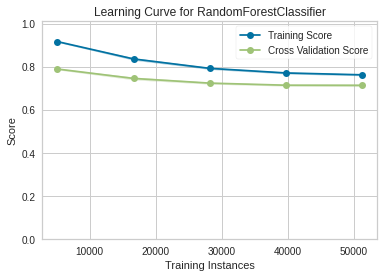

<AxesSubplot:title={'center':'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [20]:
visualizer = LearningCurve(modelo_pipe, cv=cv, scoring='recall_weighted', n_jobs=4, random_state = 123)
visualizer.fit(X, y)    
plt.ylim((0,1.01)) # Fit the data to the visualizer
visualizer.show() 

Pela curva apresentada, vemos que existe a tendência do modelo atingir uma performance muito parecida no treinamento e no teste à medida que aumentamos o número de registros de treinamento. Talvez com uma base maior tenhamos um aumento de performance.

## Teste 

Agora que já treinamos o modelo e definimos os hiperparâmetros que maximizam nossa métrica, iremos comparar a perfomance do treino com a de teste.

In [21]:
# Previsão para o teste
y_pred_test = modelo_pipe.predict(df_test.drop(target,axis=1))

In [22]:
recall_score_teste = recall_score(df_test['dano_na_plantacao'], y_pred_test,average='weighted')
print(f'O modelo obteve um score de teste para o recall de: {recall_score_teste}')

O modelo obteve um score de teste para o recall de: 0.7039375


Temos que avaliar nossa métrica versus a métrica da solução que já está disponível na empresa. Na ausência de um modelo existente, podemos utilizar "naive classifiers" construídos com regras simples, para medir qual ganho de performance temos ao implementarmos o modelo de machine-learning.

# Previsões 2020

Por fim, iremos fornecer as previsões para a safra de 2020. Além disso, vamos exportar nosso modelo binarizado para utilização.

In [51]:
# Lendo os dados da safra de 2020
df_safra_2020 = pd.read_csv(os.path.join(DATA_SAFRA_2020_PATH, DATA_SAFRA_2020_NAME), index_col=0,dtype=dicionario_tipo)
# Prevendo
previsoes_2020 = modelo_pipe.predict_proba(df_safra_2020)

In [52]:
# Transformando as previsões em Score (geralmente é mais fácil explicar em forma de score 
# do que em forma de probabilidade) para o cliente

columns_predict = ['Score_Saudável','Score_Danos_Outros_Motivos','Score_Danos_Pesticida']
previsoes_2020 = previsoes_2020*1000
df_previsoes_2020 = pd.DataFrame(previsoes_2020, columns=columns_predict)
df_previsoes_2020 = df_previsoes_2020.round(2)

In [53]:
# Pre processando os dados de treino e teste para salvar em uma pasta isolada 
df_train_processed = modelo_pipe['preprocessor'].transform(df_train)
df_test_processed = modelo_pipe['preprocessor'].transform(df_test)
df_train_processed = pd.DataFrame(df_train_processed, columns = variaveis_numericas+variaveis_categoricas)
df_train_processed['dano_na_plantacao'] = df_train['dano_na_plantacao']
df_test_processed = pd.DataFrame(df_test_processed, columns = variaveis_numericas+variaveis_categoricas)
df_test_processed['dano_na_plantacao'] = df_test['dano_na_plantacao']
df_train_processed.to_csv(os.path.join(DATA_PROCESSED_PATH, DATA_TRAIN_PROCESSED_NAME), index=False)
df_test_processed.to_csv(os.path.join(DATA_PROCESSED_PATH, DATA_TEST_PROCESSED_NAME), index=False)

In [54]:
# Salvando previsões, modelo e salvando as bases de treino e teste preprocessadas 
df_previsoes_2020['Identificador_Agricultor'] = df_safra_2020['Identificador_Agricultor'].values
df_previsoes_2020.to_csv(os.path.join(PREDICT_2020_PATH, PREDICT_2020_NAME), index=False)

In [55]:
df_previsoes_2020

,Score_Saudável,Score_Danos_Outros_Motivos,Score_Danos_Pesticida,Identificador_Agricultor
0,992.75,7.25,0.00,SCROP80001
1,988.52,11.48,0.00,SCROP80002
2,992.84,7.16,0.00,SCROP80003
3,979.53,20.47,0.00,SCROP80004
4,985.64,14.36,0.00,SCROP80005
...,...,...,...,...
8853,559.26,440.74,0.00,SCROP88854
8854,581.88,418.12,0.00,SCROP88855
8855,412.45,568.54,19.01,SCROP88856
8856,527.35,462.39,10.27,SCROP88857


In [56]:
# Exportando o modelo em formato binarizado 
with open(os.path.join(MODEL_PATH, MODEL_NAME), 'wb') as model:
    cloudpickle.dump(modelo_pipe, model)